## 1. 모델링

사전설정 (모델 훈련과 예측 모두 공통)

In [46]:
import os

model_save_path = "saved_model1"
# cols = ["KOSPI", "KOSPI_VOL", "CR", "GOLD", "NASDAQ", "DOW", "NIKKEI", "SHANGHAI", "INDI", "FOREIGN", "ORG"]
# cols = ["KOSPI", "KOSPI_VOL", "CR", "GOLD", "NASDAQ", "DOW", "NIKKEI", "SHANGHAI"]
cols = ["KOSPI", "KOSPI_START", "KOSPI_HIGH", "KOSPI_LOW", "NASDAQ", "DOW", "CR", "GOLD"]
len_x_ARMA = 60
len_y_nextday = 20
scale_method = "norm"

# 패키지 캐시 모두 지우기 (tf 등 이전에 남은 가비지가 영향을 미칠 수 있음)
for dir_ in ["/Users/hrdkdh/Documents/GitHub/predict/", "/Users/hrdkdh/venv/"]:
    os.system("find {} | grep -E '(__pycache__|\.pyc$|\pyo$)' | xargs rm -rf".format(dir_))

1-1) 데이터 크롤링

In [47]:
from kospi_predict import Crawler

crawler = Crawler(crawl_page_max=30, perPage=100)
# crawler.crawlData(cols, save=True)
crawler.loadFromSavedFile(cols)
df_crawled = crawler.removeNan()
df_crawled = df_crawled.loc[:2000]
df_crawled

,date,KOSPI,KOSPI_START,KOSPI_HIGH,KOSPI_LOW,NASDAQ,DOW,CR,GOLD
0,2022-03-17,2694.51,2703.27,2714.00,2694.51,13436.553,34063.10,1213.0,1940.00
1,2022-03-16,2659.23,2649.85,2659.90,2630.03,12948.621,33544.34,1234.5,1918.50
2,2022-03-15,2621.53,2630.31,2641.97,2615.08,12581.220,32945.24,1245.5,1934.75
3,2022-03-14,2645.65,2654.93,2661.76,2633.31,12843.808,32944.19,1239.0,1969.43
4,2022-03-11,2661.28,2665.95,2672.62,2647.28,13129.963,33174.07,1235.0,1993.10
...,...,...,...,...,...,...,...,...,...
1996,2014-02-03,1919.96,1930.09,1931.81,1917.64,4103.878,15698.85,1085.5,1242.10
1997,2014-01-29,1941.15,1925.93,1941.71,1925.52,4097.962,15928.56,1072.0,1253.00
1998,2014-01-28,1916.93,1907.18,1919.26,1904.05,4083.609,15837.88,1078.5,1255.75
1999,2014-01-27,1910.34,1905.91,1918.68,1899.76,4128.173,15879.11,1083.0,1267.75


1-2. 데이터 전처리

In [48]:
from kospi_predict import DataPreprocessor

dpp = DataPreprocessor(df_crawled, cols, scale_method, model_save_path)
dpp.sortByDate()
dpp.makeDiffRatio()
dpp.scalingForModeling()
dpp.makeAR(0, len_x_ARMA)
# dpp.makeMA(2, len_x_ARMA)
dpp.makeTargetYs(len_y_nextday)
dpp.cutoffData(len_x_ARMA, len_y_nextday)

자기상관 생성중... (100.00%)



In [49]:
dpp.getRemoveColByRegression(threshold=0.7)
# dpp.remove_cols

In [50]:
#상관계수로 드랍할 변수 선택하기
# dpp.getRemoveColByCorr(threshold=0.7)
# len(dpp.remove_cols)

In [51]:
#변수 선택하고 데이터 분할
dpp.df.drop(columns=dpp.remove_cols, inplace=True)
dpp.splitData()
# dpp.df.to_excel("processed_data.xlsx", index=False)
dpp.df

,date,KOSPI,KOSPI_START,KOSPI_HIGH,KOSPI_LOW,NASDAQ,DOW,CR,GOLD,X_KOSPI_AR0,...,Y_KOSPI_nextday_11,Y_KOSPI_nextday_12,Y_KOSPI_nextday_13,Y_KOSPI_nextday_14,Y_KOSPI_nextday_15,Y_KOSPI_nextday_16,Y_KOSPI_nextday_17,Y_KOSPI_nextday_18,Y_KOSPI_nextday_19,Y_KOSPI_nextday_20
0,2014-04-23,-0.715668,-0.692552,-0.706927,-0.690027,-1.077264,-1.204069,-1.910803,-0.492409,-0.715668,...,-0.761548,-0.688150,-0.689807,-0.681284,-0.676811,-0.687019,-0.694727,-0.675628,-0.671471,-0.689413
1,2014-04-24,-0.721008,-0.702223,-0.722373,-0.707512,-1.087620,-1.206218,-1.920720,-0.496940,-0.721008,...,-0.688150,-0.689807,-0.681284,-0.676811,-0.687019,-0.694727,-0.675628,-0.671471,-0.689413,-0.722876
2,2014-04-25,-0.791196,-0.727900,-0.749848,-0.764527,-1.081203,-1.206218,-1.890968,-0.457939,-0.791196,...,-0.689807,-0.681284,-0.676811,-0.687019,-0.694727,-0.675628,-0.671471,-0.689413,-0.722876,-0.671760
3,2014-04-28,-0.797510,-0.800356,-0.802240,-0.771468,-1.103055,-1.229910,-2.009979,-0.417756,-0.797510,...,-0.681284,-0.676811,-0.687019,-0.694727,-0.675628,-0.671471,-0.689413,-0.722876,-0.671760,-0.684388
4,2014-04-29,-0.809322,-0.785560,-0.803257,-0.794464,-1.103403,-1.215160,-2.097253,-0.478030,-0.809322,...,-0.676811,-0.687019,-0.694727,-0.675628,-0.671471,-0.689413,-0.722876,-0.671760,-0.684388,-0.729900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2022-02-09,1.306009,1.311558,1.276789,1.306878,1.935189,1.998189,1.183484,1.641615,1.306009,...,0.990188,1.063744,1.122725,1.134142,1.248738,1.160213,0.996791,0.920736,1.073109,1.023020
1916,2022-02-10,1.314112,1.350481,1.315640,1.328735,2.024040,2.049781,1.193401,1.663479,1.314112,...,1.063744,1.122725,1.134142,1.248738,1.160213,0.996791,0.920736,1.073109,1.023020,0.981901
1917,2022-02-11,1.250395,1.223543,1.259360,1.258050,1.932543,1.960808,1.203319,1.645358,1.250395,...,1.122725,1.134142,1.248738,1.160213,0.996791,0.920736,1.073109,1.023020,0.981901,0.918447
1918,2022-02-14,1.136668,1.160364,1.149828,1.133954,1.814096,1.875712,1.213236,1.762164,1.136668,...,1.134142,1.248738,1.160213,0.996791,0.920736,1.073109,1.023020,0.981901,0.918447,1.017627


1-3) 모델 훈련하고 생성

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 560)               0         
                                                                 
 dense_26 (Dense)            (None, 1024)              574464    
                                                                 
 dense_27 (Dense)            (None, 20)                20500     
                                                                 
 dense_28 (Dense)            (None, 1024)              21504     
                                                                 
 dense_29 (Dense)            (None, 20)                20500     
                                                                 
Total params: 636,968
Trainable params: 636,968
Non-trainable params: 0
_________________________________________________________________


2022-03-18 00:03:53.082613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-18 00:03:53.837255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


모델 생성 완료1500/1500(100%) loss : 0.0018, mae : 0.0317, mse : 0.0018 / val_loss : 0.0054, val_mae : 0.0529, val_mse : 0.0054                              
INFO:tensorflow:Assets written to: kospi_predictor_model/saved_model1/assets
모델 저장 완료
check point : cp-1388


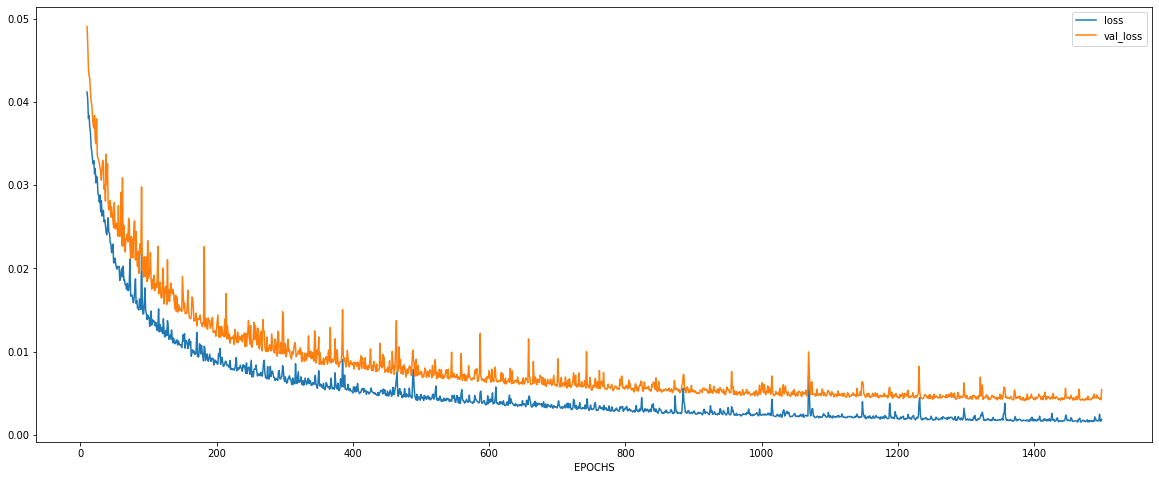

In [70]:
from kospi_predict import ModelMaker

maker = ModelMaker(
    dpp.y_list,
    dpp.df_train,
    dpp.df_test,
    perceptron_vol = 1024,
    dense_vol1 = 1,
    dense_vol2 = 1,
    activation_method = "relu",
    optimizer_str = "Adam",
    model_save_path = model_save_path)
maker.makeModel(EPOCHS=1500, batch_size=32, learning_rate=0.00005, save_by_checkpoint=True)

INFO:tensorflow:Assets written to: kospi_predictor_model/saved_model1/assets
모델 저장 완료
check point : cp-1388


2022-03-18 00:10:52.782472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


,y_no,test_mae,test_mse
0,0,0.041601,0.003167
1,1,0.047846,0.003718
2,2,0.047869,0.003898
3,3,0.043364,0.003628
4,4,0.044465,0.003758
5,5,0.045855,0.003830
6,6,0.047264,0.004605
7,7,0.041442,0.003103
8,8,0.041952,0.003425
9,9,0.043548,0.003636


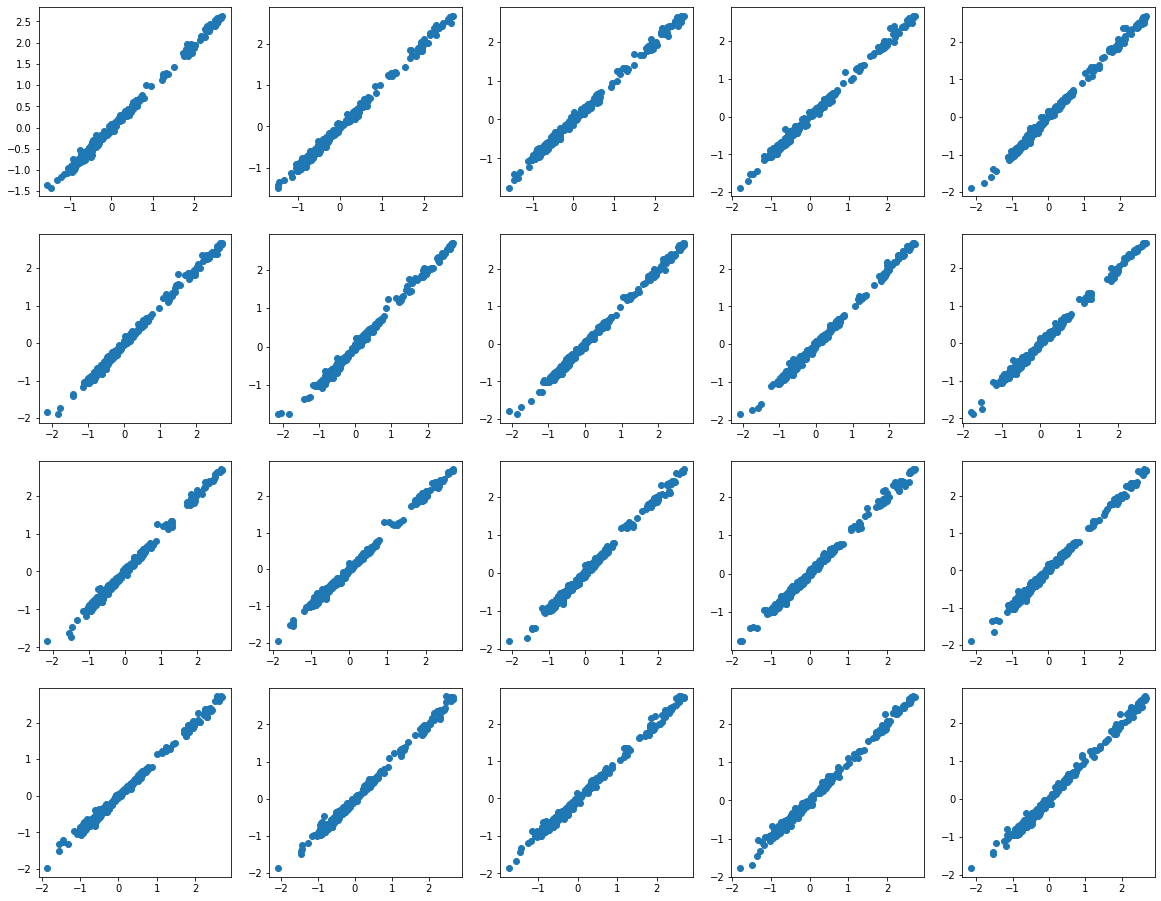

In [71]:
maker.saveModelByCheckpoint(-1)
maker.validateModel()
maker.test_error

## 2. 최근 데이터로 20일 간의 KOSPI 지수 예측

2-1) 데이터 수집

In [72]:
from kospi_predict import Crawler

#예측을 위해서는 현재기준 이전 10일간의 데이터만 있으면 됨 (len_x_ARMA가 10일때)
crawler_pred = Crawler(crawl_page_max=1, perPage=100) #이전 추세도 볼겸 넉넉히 수집
crawler_pred.crawlData(cols)
df_crawled_pred = crawler_pred.removeNan()
df_crawled_pred


KOSPI : 데이터 수집중...
KOSPI_START : 데이터 수집중...
KOSPI_HIGH : 데이터 수집중...
KOSPI_LOW : 데이터 수집중...
NASDAQ : 1번째 페이지 데이터 수집중...
DOW : 1번째 페이지 데이터 수집중...
CR : 1번째 페이지 데이터 수집중...


,date,KOSPI,KOSPI_START,KOSPI_HIGH,KOSPI_LOW,NASDAQ,DOW,CR,GOLD
0,2022-03-17,2694.51,2703.27,2714.00,2694.51,13436.553,34063.10,1213.0,1940.00
1,2022-03-16,2659.23,2649.85,2659.90,2630.03,12948.621,33544.34,1234.5,1918.50
2,2022-03-15,2621.53,2630.31,2641.97,2615.08,12581.220,32945.24,1245.5,1934.75
3,2022-03-14,2645.65,2654.93,2661.76,2633.31,12843.808,32944.19,1239.0,1969.43
4,2022-03-11,2661.28,2665.95,2672.62,2647.28,13129.963,33174.07,1235.0,1993.10
...,...,...,...,...,...,...,...,...,...
90,2021-11-03,2975.71,3020.36,3020.87,2969.01,15649.603,36052.63,1182.0,1781.65
91,2021-11-02,3013.49,2995.58,3034.30,2995.58,15595.915,35913.84,1176.5,1794.81
92,2021-11-01,2978.94,2984.18,2991.81,2976.87,15498.389,35819.56,1178.5,1784.17
93,2021-10-29,2970.68,3025.67,3030.17,2965.40,15448.118,35730.48,1174.0,1792.93


2-2) 데이터 전처리

In [73]:
from kospi_predict import DataPreprocessor

#아래는 예측을 위한 전처리
dpp_pred = DataPreprocessor(df_crawled_pred.loc[:100], cols, scale_method, model_save_path)
dpp_pred.sortByDate()
dpp_pred.makeDiffRatio()
dpp_pred.scalingForPredict()
dpp_pred.makeAR(0, len_x_ARMA)
# dpp_pred.makeMA(2, len_x_ARMA)
dpp_pred.cutoffData(len_x_ARMA, 0)

자기상관 생성중... (100.00%)



2-3) 예측

2022-03-18 00:10:58.417085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


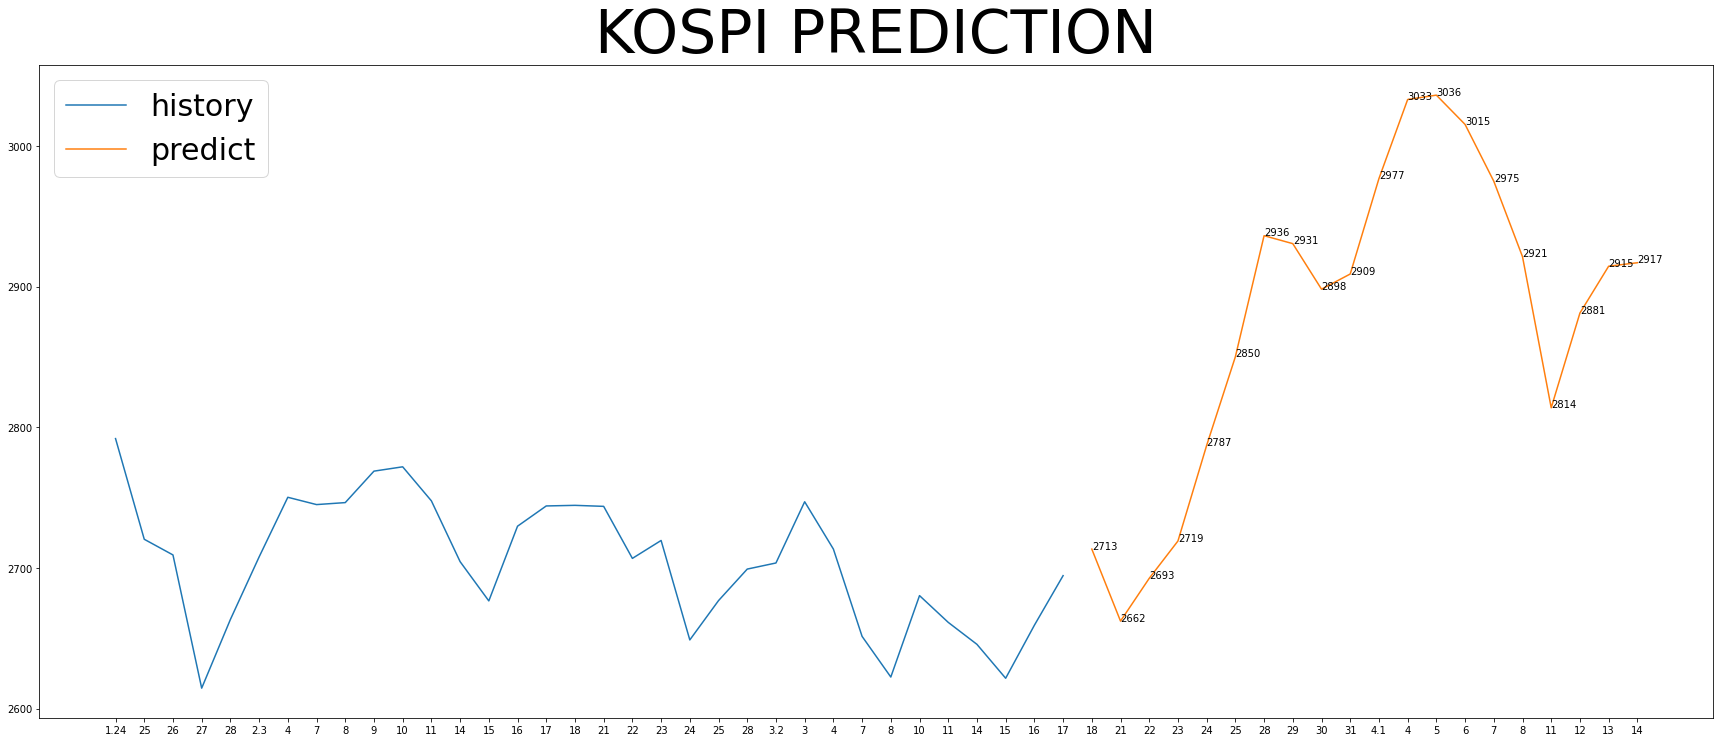

In [74]:
from kospi_predict import Predictor

#2.18 기준으로 20일 뒤까지 예측하고 시각화

predictor = Predictor(dpp_pred.df, scale_method = scale_method, model_save_path=model_save_path)
predictor.predict()
predictor.showPredictionPlot()

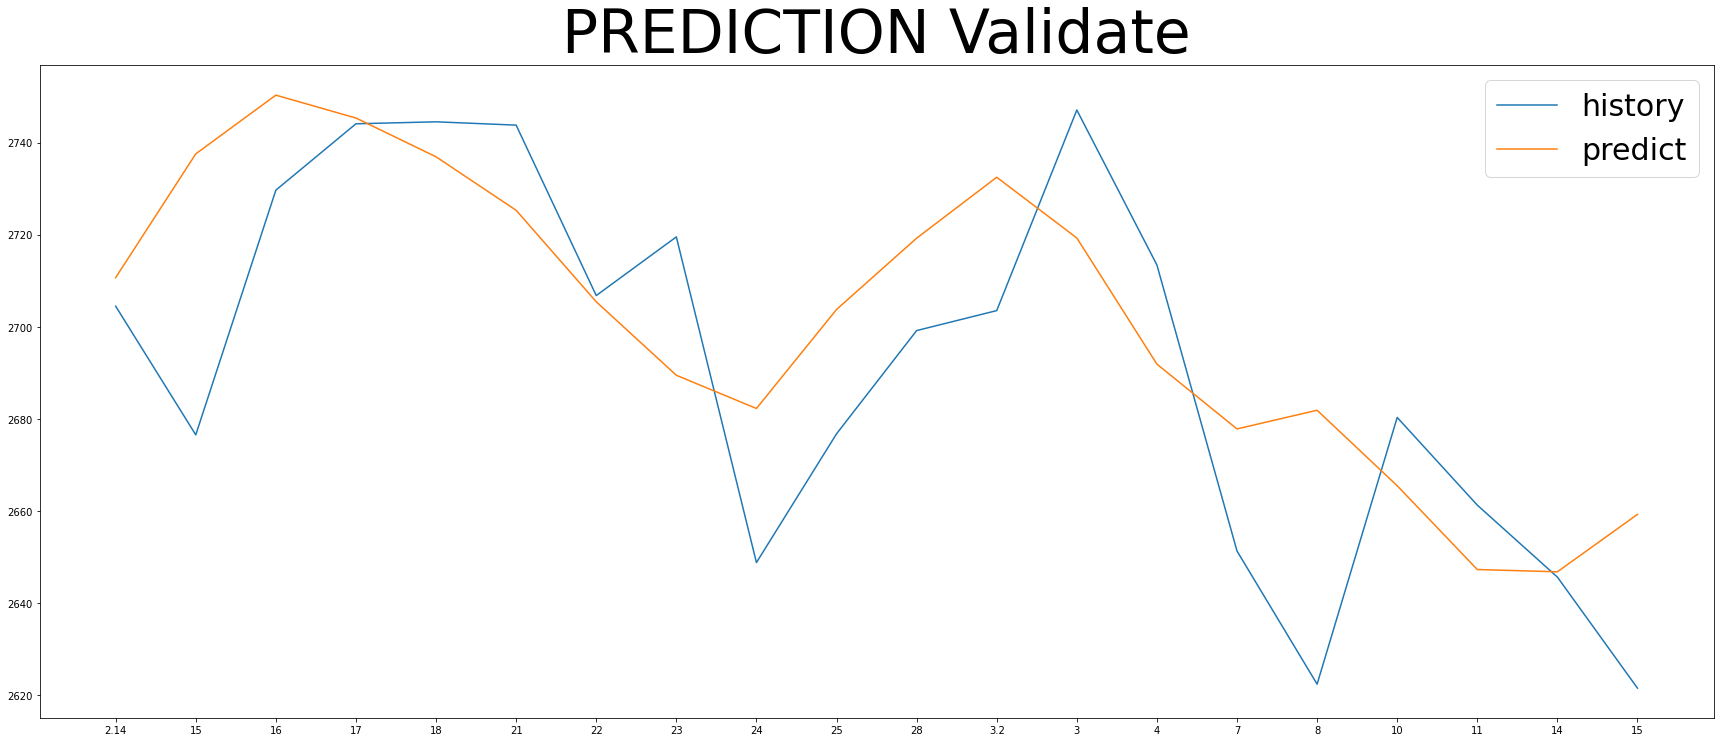

In [77]:
#실제 기록과 예측값을 비교하여 예측이 얼마나 잘 맞는지 확인한다
history_before = 23
df_result = predictor.predict(history_before)
predictor.showPredictionByHistory(df_result, history_before)

In [78]:
len(predictor.x_cols)
predictor.saveModelToJS()